<a href="https://colab.research.google.com/github/RoyElkabetz/Q_Learning_course/blob/main/dueling_ddqn_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Q_Learning_course.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/Q_Learning_course")

Cloning into 'Q_Learning_course'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 206 (delta 103), reused 130 (delta 39), pack-reused 0
Receiving objects: 100% (206/206), 17.34 MiB | 5.57 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [2]:
## uncomment to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# check GPU parameters
!nvidia-smi

Fri Aug 20 11:36:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install --quiet gym
!pip install --quiet atari_py

In [5]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2021-08-20 11:36:53--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   481KB/s    in 23s     

2021-08-20 11:37:17 (464 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin fr

In [6]:
import numpy as np
import gym
from q_learning_agents import DuelingDoubleDeepQNAgent
from utils import plot_learning_curve, make_env

record = False
load_checkpoint = False

env = make_env('PongNoFrameskip-v4')
if record:
    env = gym.wrappers.Monitor(env, "recording")
best_score = -np.inf
n_games = 300
agent = DuelingDoubleDeepQNAgent(gamma=0.99, epsilon=1.0, lr=1e-4,
                          input_dims=(env.observation_space.shape),
                          n_actions=env.action_space.n,
                          mem_size=20000,
                          eps_min=0.1,
                          batch_size=32,
                          replace=1000,
                          eps_dec=1e-5,
                          chkpt_dir='gdrive/MyDrive/Checkpoints/',
                          algo='DuelingDoubleDeepQNAgent',
                          env_name='PongNoFrameskip-v4')
if load_checkpoint:
    agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr_' + str(agent.lr) + '_' + str(n_games) + '_games'
figure_file = 'gdrive/MyDrive/Checkpoints/' + fname + '.png'

n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()

    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, int(done))
            agent.learn()

        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'score: ', score, 'average score %.1f best score %.1f epsilon %.2f' %
          (avg_score, best_score, agent.epsilon), 'steps ', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)
env.close()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/content/Q_Learning_course/q_learning_agents.py:462: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  q_next[dones] = 0.0


episode  0 score:  -17.0 average score -17.0 best score -inf epsilon 0.99 steps  1230
... saving checkpoint ...
... saving checkpoint ...
episode  1 score:  -20.0 average score -18.5 best score -17.0 epsilon 0.98 steps  2132
episode  2 score:  -19.0 average score -18.7 best score -17.0 epsilon 0.97 steps  3069
episode  3 score:  -19.0 average score -18.8 best score -17.0 epsilon 0.96 steps  4147
episode  4 score:  -19.0 average score -18.8 best score -17.0 epsilon 0.95 steps  5091
episode  5 score:  -21.0 average score -19.2 best score -17.0 epsilon 0.94 steps  5991
episode  6 score:  -20.0 average score -19.3 best score -17.0 epsilon 0.93 steps  6863
episode  7 score:  -21.0 average score -19.5 best score -17.0 epsilon 0.92 steps  7780
episode  8 score:  -21.0 average score -19.7 best score -17.0 epsilon 0.91 steps  8573
episode  9 score:  -19.0 average score -19.6 best score -17.0 epsilon 0.90 steps  9749
episode  10 score:  -21.0 average score -19.7 best score -17.0 epsilon 0.89 ste

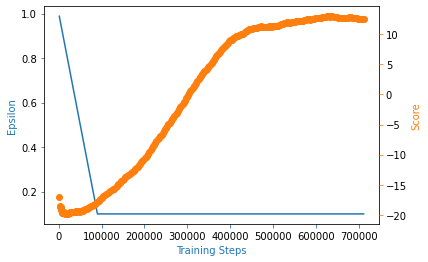

In [7]:
plot_learning_curve(steps_array, scores, eps_history, figure_file)